In [2]:
import numpy as np
import CompleteHist as ch
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy.optimize import leastsq
from sklearn.cross_validation import KFold
from sklearn import cross_validation
%matplotlib inline

In [3]:
ch.parseData()
ch.parsePrune('soft')

In [4]:
prune = ch.getPrune()
raw = ch.getData()

In [5]:
def smooth(data,const=0.04,n=25):
    out = list()
    for i in range(n,len(data[1])-n):
        temp = list()
        y = data[1][i]
        for j in data[1][i-n:i+n]:
            if np.abs(j-y) < const:
                temp.append(j)
        if len(temp) > 0:
            out.append(np.mean(temp))
    return np.array([np.array(data[0][n:len(data[0])-n]),np.array(out)])

In [6]:
def clean(data):
    left = min(data[0])
    right = max(data[0])
    left += 0.1
    right -= 0.1
    left = ch.search(data,left)
    right = ch.search(data,right)
    return np.array([np.array(data[0][left:right]),np.array(data[1][left:right])])

In [7]:
def nospike(data,const=0.03,n=4):
    outy = list()
    outx = list()
    for i in range(n,len(data[1])-n):
        temp = list()
        y = data[1][i]
        x = data[0][i]
        for j in data[1][i-n:i+n]:
            if not j==y:
                temp.append(j)
        avg = np.mean(temp)
        if np.abs(y-avg) < const:
            outy.append(y)
            outx.append(x)
    return np.array([np.array(outx),np.array(outy)])

In [8]:
def cutData(data,points):
    outx = list()
    outy = list()
    for i in points:
        l = ch.search(data,i[0])
        r = ch.search(data,i[1]) + 1
        outx.extend(data[0][l:r])
        outy.extend(data[1][l:r])
    return np.array([np.array(outx),np.array(outy)])

In [9]:
def val(data):
    h = np.mean(data[1]) + np.random.rand()
    a = (np.std(data[1]) + np.random.rand())/10.0
    f = 2*np.pi/7.0
    val = [h,a,f,np.random.rand(),np.random.rand()+1.33]
    return val

In [10]:
def zeromean(data):
    out = np.array(data[1]-np.mean(data[1]))
    return np.array([data[0],out])

In [11]:
def plotFig(data,fitbit,left=0,right=0):
    xa = fitbit
    freq = xa[2]
    amp = xa[1] 
    phasel = xa[3]*np.pi
    phaser = xa[4]*np.pi
    height =  xa[0]
    if left == 0:
        posleft = data[0][0]
    else:
        posleft = left
    if right == 0:
        posright = data[0][-1]
    else:
        posright = right
    xpos = np.linspace(posleft,posright,10000)
    ytargl = height + amp*np.sin(freq*xpos + phasel)
    ytargr = height + amp*np.sin(freq*xpos + phaser)
    plt.plot(data[0],data[1])
    plt.plot(xpos,ytargl,'k',linewidth=2)
    if phaser != 0:
        plt.plot(xpos,ytargr,'r',linewidth=2)

In [12]:
def fit(data):
    c = clean(data)
    s = smooth(c)
    zm = zeromean(s)
    v = val(zm)
    def f(vars,data):
        x = np.array(data[0])
        yaxis = np.array(data[1])       
        a = vars[0]
        f = vars[1]
        pl = vars[2]
        pr = vars[3]
        midpoint = len(x)/2
        ol = int(len(x)*0.10)
        lw = np.zeros(len(x))
        lw[:midpoint] = 1.0
        lw[midpoint:midpoint+ol] = np.arange(0,1,1.0/(ol))[::-1]
        rw = np.zeros(len(x))
        rw[midpoint:] = 1.0
        rw[midpoint-ol:midpoint] = np.arange(0,1,1.0/(ol))
        model = (a*lw*np.sin(f*x+pl*np.pi)+a*rw*np.sin(f*x+pr*np.pi))
        return (yaxis-model)
    result = leastsq(f, v, args=(test))
    print result[1]
    a = result[0]
    return a

In [13]:
def minfit(data,i=0.13):
    def f(vars,data,i):
        x = np.array(data[0])
        yaxis = np.array(data[1])
        h = vars[0]
        a = vars[1]
        f = vars[2]
        pl = vars[3]
        pr = vars[4]
        midpoint = len(x)/2
        ol = int(len(x)*i)
        lw = np.zeros(len(x))
        lw[:midpoint] = 1.0
        for j in range(ol):
            lw[midpoint+j] = 1.0-float(j/ol)
        rw = np.zeros(len(x))
        rw[midpoint:] = 1.0
        for j in range(ol):
            rw[midpoint-j] = 1.0-float(j/ol)
        model = (h + a*lw*np.sin(f*x+pl*np.pi)+a*rw*np.sin(f*x+(pr)*np.pi))
        return sum(((yaxis-model))**2)
    hold = list()
    cost = 10000
    for j in range(1,10):
        v = val(data)
        result = minimize(f, v, args=(data,i),method='nelder-mead',options={'xtol': 1e-9})
        if result['fun'] < cost:
            hold = result['x']
            cost = result['fun']
        print "Subrun: " + str(j)
    return hold,cost

In [14]:
def sectiondata(data,dV=7.0,n=20):
    zm = zeromean(smooth(clean(data)))
    xmin = zm[0][0]
    xmax = zm[0][-1]
    step = (xmax-xmin)/n
    cstep = xmin
    out = list()
    while cstep<xmax:
        if cstep-dV/2.0 < xmin:
            xl = xmin
        else:
            xl = cstep-dV/2.0
        if cstep+dV/2.0 > xmax:
            xr = xmax
        else:
            xr = cstep+dV/2.0
        li = ch.search(zm,xl)
        ri = ch.search(zm,xr)
        out.append([xl,xr,np.array(zm[:,li:ri])])
        cstep += step
    return out

In [16]:
def plotFit(data,mf):
    data = zeromean(smooth(clean(data)))
    plotFig(data,mf[2],mf[0],mf[1])

In [17]:
def findedge(data,d=0.04,n=5):
    out = list()
    y = data[1]
    for i in range(n,len(y)-n):
        if np.abs(np.mean(y[i-n:i+1])-np.mean(y[i+1:i+n+1]))>d:
            out.append(i)
    return out
def pickedge(data,d=0.04,n=5):
    fe = findedge(data,d,n)
    out = list()
    y = data[1]
    x = data[0]
    i = 0
    while i < len(fe):
        temp = list()
        temp.append(fe[i])
        j = 1
        while True:
            if (i+j) >= len(fe):
                if len(temp)==1:
                    out.append(temp[len(temp)/2])
                    break
                else:
                    out.append(temp[len(temp)/2])
                    break
            if np.abs(y[fe[i]]-y[fe[i+j]])<0.06 and np.abs(x[fe[i]]-x[fe[i+j]])<0.03:
                temp.append(fe[i+j])
                j += 1
            else:
                if len(temp)==1:
                    out.append(temp[0])
                    break
                else:
                    out.append(temp[len(temp)/2])
                    break
        i += j
    return out
def selectedge(data,d=0.04,n=5):
    pe = pickedge(data,d,n)
    y = data[1]
    x = data[0]
    out = list()
    out.append([0,pe[0]])
    for i in range(len(pe)-1):
        if np.abs(y[pe[i]+1]-y[pe[i+1]-1]) < 0.06:
            out.append([pe[i],pe[i+1]])
    return out
def smoothedge(data,d=0.04,n=5):
    se = selectedge(data,d,n)
    out = np.array(data)
    for i in se:
        if i[1]-i[0]>10:
            clip = data[1][i[0]:i[1]]
            hold = list()
            for j in range(len(clip)):
                if j > 5 and j < len(clip)-5:
                    hold.append(np.mean(clip[j-5:j+6]))
                elif j <= 5:
                    hold.append(np.mean(clip[j:j+6]))
                elif j >= len(clip)-5:
                    hold.append(np.mean(clip[j-5:j+1]))
            out[1][i[0]:i[1]] = np.array(hold)
    return out

In [20]:
c = clean(prune[0])
fe = findedge(c,d=0.09)
pe = pickedge(c)
xx = [c[0,i] for i in fe]
yx = [c[1,i] for i in fe]
xxx = [c[0,i] for i in pe]
yxx = [c[1,i] for i in pe]

In [21]:
se = selectedge(c)

In [22]:
se = smoothedge(prune[0])

In [18]:
def normdata(data):
    data = np.array(data)
    mu = np.mean(data[1])
    data[1] -= mu
    sigma = np.std(data[1])
    data[1] /= sigma
    return data, mu, sigma

In [19]:
def step(data,direction):
    l = len(data[0])
    out = list()
    mid = data[0][l/2]
    if direction == 'left':
        for x in data[0]:
            if x > mid: 
                if np.exp((mid-x)/.5) > 0.10:
                    out.append(np.exp((mid-x)/.5))
                else:
                    out.append(0.0)
            else:
                out.append(1.0)
    else:
        for x in data[0]:
            if x < mid:
                if np.exp((x-mid)/.5) > 0.10:
                    out.append(np.exp((x-mid)/.5))
                else:
                    out.append(0.0)
            else:
                out.append(1.0)
    return np.array(out)

In [20]:
def gradientdesc(data,val,left,right,alpha=0.1,lam=1.0):
    y = np.array(data[1])
    x = np.array(data[0])
    l = float(len(data[1]))
    h = val[0]
    a = val[1]
    f = val[2]
    pl = val[3]
    pr = val[4]
    funl = (h+a*np.sin(f*x+pl*np.pi))
    funr = (h+a*np.sin(f*x+pr*np.pi))
    dh = lam*1.0/l*np.sum((-y+funl)*left+(funr-y)*right)
    da = lam*1.0/l*np.sum(((-y+funl)*left+(funr-y)*right)*(np.sin(f*x+pl*np.pi)*left+np.sin(f*x+pr*np.pi)*right))+alpha/l*a
    df = lam*1.0/l*np.sum(((-y+funl)*left+(funr-y)*right)*(a*np.cos(f*x+pl*np.pi)*x*left+a*np.cos(f*x+pr*np.pi)*x*right))+alpha/l*f
    dpl = lam*1.0/l*np.sum(((-y+funl)*left+(funr-y)*right)*(a*np.cos(f*x+pl*np.pi)*np.pi*left))+alpha/l*pl
    dpr = lam*1.0/l*np.sum(((-y+funl)*left+(funr-y)*right)*(a*np.cos(f*x+pr*np.pi)*np.pi*right))+alpha/l*pr
    h -= dh
    a -= da
    f -= df
    pl -= dpl
    pr -= dpr
    return [h,a,f,pl,pr]

In [21]:
def fitval(data,n=200,alpha=1.0,lam=1.0):
    v = val(data)
    left = step(data,'left')
    right = step(data,'right')
    for i in range(n):
        v = gradientdesc(data,v,left,right,alpha,lam)
    return v

In [22]:
def crossval(data,n=200,alpha=0.5,lam=1.0,k=10):
    kf = KFold(len(data[0]),n_folds=k)
    cost = list()
    for train, test in kf:
        train, test = data[:,train], data[:,test]
        val = fitval(train,n,alpha,lam)
        left = step(test,'left')
        right = step(test,'right')
        y = np.array(test[1])
        x = np.array(test[0])
        h = val[0]
        a = val[1]
        f = val[2]
        pl = val[3]
        pr = val[4]
        cost.append(np.sum((y-(h+a*np.sin(f*x+pl*np.pi))*left-(h+a*np.sin(f*x+pr*np.pi))*right)**2))
    return val,np.mean(cost)

In [23]:
def shuffsplit(data,n=200,alpha=0.5,lam=1.0,k=10):
    kf = cross_validation.ShuffleSplit(len(data[1]), n_iter=10,test_size=.35)
    cost = list()
    for train, test in kf:
        train, test = data[:,train], data[:,test]
        val = fitval(train,n,alpha,lam)
        left = step(test,'left')
        right = step(test,'right')
        y = np.array(test[1])
        x = np.array(test[0])
        h = val[0]
        a = val[1]
        f = val[2]
        pl = val[3]
        pr = val[4]
        cost.append(np.sum((y-(h+a*np.sin(f*x+pl*np.pi))*left-(h+a*np.sin(f*x+pr*np.pi))*right)**2))
    return val,np.mean(cost)

In [85]:
cost = np.inf
d = prune[1][:,1294:4552]
d,m,s = normdata(d)
a = 0
lam = 0
params = list()
for i in [3,1,.3,.1]:
    print "Running"
    for k in [3,1,.3,.1]:
        for j in range(10):
            v,c = crossval(d,n=130,alpha=i,lam=k)
            if c < cost:
                cost = c
                params = v
                a = i
                lam = k

Running
Running
Running
Running
Running
Running
Running
Running
Running
Running


In [139]:
cost = np.inf
d = prune[1][:,1000:6700]
d,m,s = normdata(d)
a = 0
lam = 0
params = list()
for i in [3,1,.3,.1]:
    print "Running"
    for k in [3,1,.3,.1]:
        for j in range(10):
            v,c = shuffsplit(d,n=200,alpha=i,lam=k)
            if c < cost:
                cost = c
                params = v
                a = i
                lam = k

Running
Running
Running
Running


In [106]:
params.append(params[3]-1.33)

In [140]:
plotFig(d,params)

In [133]:
print a,lam

0.01 0.01


In [63]:
d = prune[1][:,3294:6552]
cost = np.inf
left = step(d,'left')
right = step(d,'right')
best = list()
for k in [1,.5,.1,.05,.01,.005,.001]:
    v = val(d)
    for i in range(2000):
        v = gradientdesc(d,v,left,right,alpha=k)
    h = v[0]
    a = v[1]
    f = v[2]
    pl = v[3]
    pr = v[4]
    x = d[0]
    y = d[1]
    c = np.sum(((y-(h+a*np.sin(f*x+pl*np.pi)))*left)**2+((y-(h+a*np.sin(f*x+pr*np.pi)))*right)**2)
    print c
    if cost > c:
        cost = c
        best = [v,k]

15.5595761179
14.7427106288
16.7408567495
16.332516697
14.4020503676
17.18169557
15.0826430392


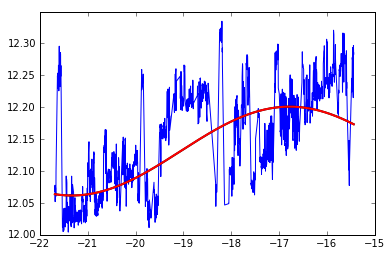

In [64]:
plotFig(d,best[0])

In [62]:
best[1]

0.001

In [28]:
best

0.1

In [49]:
d = smooth(prune[1][:,2500:6600])
left = step(d,'left')
right = step(d,'right')
costs = list()
best = np.inf
paramhold = list()
for k in [.5,.1,.05,.01,.005,.001,0.0005,.0001]:
    cost = list()
    v = val(d)
    for i in range(1000):
        v = gradientdesc(d,v,left,right,alpha=k)
        h = v[0]
        a = v[1]
        f = v[2]
        pl = v[3]
        pr = v[4]
        x = d[0]
        y = d[1]
        c = np.sum((y-(h+a*np.sin(f*x+pl*np.pi))*left-(h+a*np.sin(f*x+pr*np.pi))*right)**2/y)
        cost.append(c)
    costs.append(cost)
    if cost[-1] < best:
        paramhold = [v,k]
        best = cost[-1]

In [50]:
paramhold

[[12.144266237496247,
  -0.079520499760741034,
  0.83420820552611397,
  0.22263097722227229,
  -0.022056269109833014],
 0.05]

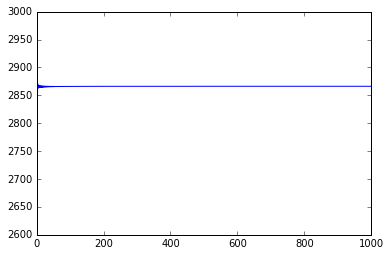

In [51]:
plt.plot(costs[2])

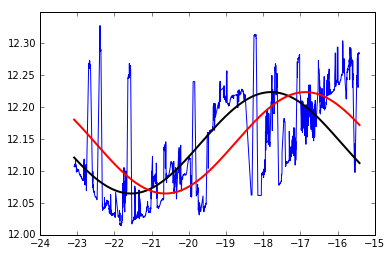

In [52]:
plotFig(d,paramhold[0])

In [358]:
hold

[[12.145795150270027,
  -0.084669132525197643,
  0.8388087210861449,
  0.36216320623211373,
  0],
 0.0001]

In [305]:
def gradientdesc(data,val,alpha=0.1,lam=1.0):
    y = np.array(data[1])
    x = np.array(data[0])
    l = float(len(data[1]))
    h = val[0]
    a = val[1]
    f = val[2]
    pl = val[3]
    pr = 0
    funl = (h+a*np.sin(f*x+pl*np.pi))
    dh = lam*1.0/l*np.sum(-y+funl*left)
    da = lam*1.0/l*np.sum((-y+funl*left)*(np.sin(f*x+pl*np.pi)))+alpha/l*a
    df = lam*1.0/l*np.sum((-y+funl*left)*(a*np.cos(f*x+pl*np.pi)*x))+alpha/l*f
    dpl = lam*1.0/l*np.sum((-y+funl*left)*(a*np.cos(f*x+pl*np.pi)*np.pi))+alpha/l*pl
    h -= dh
    a -= da
    f -= df
    pl -= dpl
    return [h,a,f,pl,pr]

In [359]:
A = np.linspace(0,2*paramhold[0][1],1000)
F = np.linspace(0,2*paramhold[0][2],1000)

In [294]:
2*np.pi/9.0

0.6981317007977318

In [360]:
darray = list()
for i in A:
    hold = list()
    for j in F:
        hold.append(np.sum((y-(h+i*np.sin(j*x+pl*np.pi)))**2/y))
    darray.append(np.array(hold))
darray = np.array(darray)

In [346]:
CS = plt.contour(A, F, darray, 15, linewidths=0.5, colors='k')

In [68]:
ch.search(prune[1],-27)
ch.search(prune[1],-20)

4398

In [422]:
out=list()
sd = sectiondata(prune[0],n=100)
for i in sd:
    d = i[2]
    left = step(d,'left')
    right = step(d,'right')
    v = val(d)
    for i in range(100):
        v = gradientdesc(d,v,left,right,alpha=0.001)
    out.append(v)

In [309]:
ind = 0

In [421]:
ind += 1
plotFig(sd[ind][2],out[ind])

IndexError: list index out of range

In [339]:
def multirun(d,alpha=1.0):
    cost = np.inf
    out = list()
    left = step(d,'left')
    right = step(d,'right')
    x = np.array(d[0])
    y = np.array(d[1])
    for i in range(20):
        v = val(d)
        for i in range(100):
            v = gradientdesc(d,v,left,right,alpha)
        c = np.sum(((y - (v[0] + v[1] * np.sin(v[2] * x + v[3] * np.pi)))*left) ** 2
                                   + ((y - (v[0] + v[1] * np.sin(v[2] * x + v[4] * np.pi)))*right) ** 2)
        if c < cost:
            cost = c
            out = v
    return out

In [331]:
ind

21

In [361]:
out[ind]

[-0.023574622441194713,
 -0.097878493451213563,
 1.0930941586277065,
 -0.1154783943383466,
 1.0460170637906732]

In [308]:
out=list()
for i in sectiondata(prune[1],n=100):
    d = i[2]
    out.append(multirun(d,0.001))

In [363]:
(out[ind][4]-out[ind][3])%2

1.1614954581290198

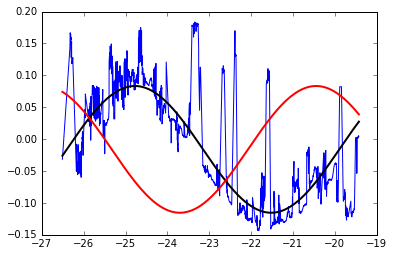

In [337]:
plotFig(sd[ind][2],out[ind])